In [2]:
import numpy as np
import os
import torch
import importlib
import data_set
import matplotlib.pyplot as plt

importlib.reload(data_set)
#加载图片相关数据
data = data_set.ImageSet()
cuda_ok = torch.cuda.is_available()
use_cuda = True & cuda_ok
device = torch.device("cuda") if use_cuda else torch.device("cpu")
print("Use cuda." if use_cuda else "Use cpu.")

Use cuda.


In [3]:
#加载一些预先训练好的model
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)
alexnet = models.alexnet(pretrained=True)
squeezenet = models.squeezenet1_0(pretrained=True)
vgg16 = models.vgg16(pretrained=True)

In [10]:
import random
#选择要attack的model
model = vgg16
model = model.to(device)
#预测而不需要改变model参数的时候一定要用eval
#否则dropout等可能导致每次预测的结果不同
model.eval() 
#改变大小界限
tolerance = 0.001
random.seed(100)
image, lable = data.__getitem__(6)
image  = image.to(device) 
#此处发现vgg16两次预测的概率不同，而且相差较大，不知道为什么原因，
# 所以在此测试一下两次预测结果是否相同
#原因是没有使用model.eval() 
y = torch.nn.functional.softmax(model(image.unsqueeze(0))[0])
print(y[lable])
y = torch.nn.functional.softmax(model(image.unsqueeze(0))[0])
print(y[lable])

tensor(0.2716, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.2716, device='cuda:0', grad_fn=<SelectBackward>)


In [11]:
#使用FGSM来生成所有的攻击图片
import fgsm
importlib.reload(fgsm)

fgsm_attack_ret = []
fgsm_success_count = 0
for i in range(data.__len__()):    
    image,label = data.__getitem__(i)
    image = image.to(device)
    r = fgsm.white_nontarget_attack(model, image, label, tolerance )
    if r[2][0] != label:  
        fgsm_success_count += 1
    fgsm_attack_ret.append(r)
    #手动释放缓存    
    del image
    torch.cuda.empty_cache()


In [12]:
#使用BIM来生成所有的攻击图片
import bim
importlib.reload(bim)

bim_attack_ret = []
bim_success_count = 0
for i in range(data.__len__()):    
    image,label = data.__getitem__(i)
    image = image.to(device)
    #每次的step为0.1 * tolerance,训练10轮
    r = bim.white_nontarget_attack(model, image, label, tolerance,0.1,20)
    if r[2][0] != label:
        bim_success_count += 1
    bim_attack_ret.append(r)
    #手动释放缓存    
    del image
    torch.cuda.empty_cache()

In [13]:
print("image count: %d, fgsm success count: %d, bim success count: %d," % (data.__len__(), fgsm_success_count, bim_success_count))

image count: 200, fgsm success count: 171, bim success count: 163,


In [14]:
#show a image result
import utils
def print_result(id, ret):
    image, label = data.__getitem__(id)
    print('label is %d "%s"' % (label, data.category_names[label]))
    print(
        'origin:\nprediction is %d(%f) "%s", \nlabel probability: %f'
        % (ret[id][1][0], ret[id][1][1], data.category_names[ret[id][1][0]], ret[id][1][2])
    )
    plt.figure()
    plt.imshow(utils.tensor2numpy(image))
    plt.show()
    print(
        'attack result:\nprediction is %d(%f) "%s", \nlabel probability: %f'
        % (ret[id][2][0], ret[id][2][1], data.category_names[ret[id][2][0]], ret[id][2][2])
    )
    plt.figure()
    plt.imshow(ret[id][0])
    plt.show()

FGSM attack result against image 6
label is 949 "strawberry"
origin:
prediction is 463(0.008110) "bucket, pail", 
label probability: 0.000594


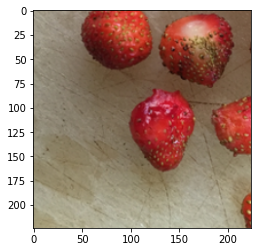

attack result:
prediction is 463(0.008225) "bucket, pail", 
label probability: 0.000519


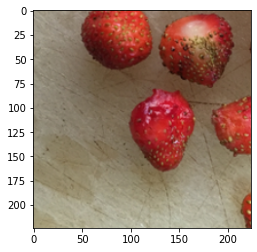

In [97]:
id = 6
print("FGSM attack result against image %d" % (id))
print_result(id, fgsm_attack_ret)

BIM attack result against image 6
label is 949 "strawberry"
origin:
prediction is 463(0.008110) "bucket, pail", 
label probability: 0.000594


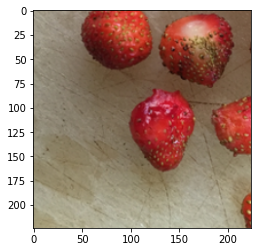

attack result:
prediction is 463(0.008168) "bucket, pail", 
label probability: 0.000514


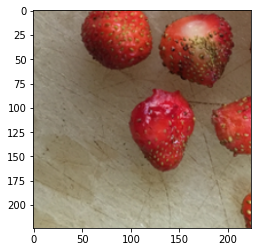

In [98]:
id = 6
print("BIM attack result against image %d" % (id))
print_result(id, bim_attack_ret)